**Installing Dependencies**

In [ ]:
# Deliverables (Git Repository)
# ○ Training code in Python preferably using Tensorflow/Pytorch ....notebook done
# ■ Input: Images folder, Attribute csv ....images and attribute done 
# ■ Output: Neural Net Model Weights ....weights done 
# ○ Inference Script in Python: ....done
# ■ Input: Test Images Folder, Trained Neural Net Model ....done 
# ■ Output: Output.csv of with predicted values similar to attribute.csv done 
# ○ ReadMe document which explains usage to-do




**Importing Packages**





In [6]:

from PIL import Image
import numpy as np
import math
import random
from tqdm import tqdm
import shutil
import os
from pathlib import Path
import pandas as pd

# PyTorch libraries
import torch
from torchvision import transforms, datasets
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

import torch
import cv2
import numpy as np
import torchvision.transforms as transforms
from torch.utils.data import Dataset

**Data Ingestion & Preparation**

In [1]:
!gdown --id 1p7-dU6rDuqZ2mxv5ac5AWndt4z19aS6j
!unzip /content/classification-assignment.zip
# removing db file
if os.path.exists("/content/classification-assignment/images/Thumbs.db"):
  os.unlink("/content/classification-assignment/images/Thumbs.db")

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1p7-dU6rDuqZ2mxv5ac5AWndt4z19aS6j
To: /content/classification-assignment.zip
100% 75.0M/75.0M [00:00<00:00, 155MB/s]


Data-Loader

In [7]:
data_df = pd.read_csv('/content/classification-assignment/attributes.csv')
data_df

,filename,neck,sleeve_length,pattern
0,cdc8cd2a-0938-4970-a3b5-f5ed9595222c1527925869...,6.0,NaN,4.0
1,11469770662809-Metersbonwe-Navy-T-shirt-485146...,5.0,3.0,9.0
2,11479107741104-Tommy-Hilfiger-Men-Navy-Blue-St...,6.0,1.0,9.0
3,f7ad67ab-eeb1-4449-8f63-7b580d2797e71532342804...,NaN,0.0,9.0
4,11516770810185-Splash-Men-Tshirts-767151677081...,6.0,3.0,9.0
...,...,...,...,...
2233,11507360109998-Nautica-Men-Blue-Striped-V-Neck...,5.0,3.0,9.0
2234,8f236dcd-4a2b-49ff-9229-981e7db946f91537273774...,6.0,NaN,5.0
2235,15cb873b-993c-422c-b9c1-96d59580fbae1535360301...,6.0,3.0,3.0
2236,bf72a615-0db6-4400-903b-6c2aa1e5831d1530608800...,6.0,3.0,1.0


In [8]:
image_name = os.listdir('/content/classification-assignment/images')
data_df = data_df[data_df.filename.isin(image_name)]
data_df.columns
data_without_na = data_df.dropna()
data_without_na[-100:].to_csv('attributes_test.csv')
df_attributes = data_without_na[:-100]

In [9]:
df_attributes = data_df[:].dropna()

# one hot encode the Neck attribute
one_hot_neck = pd.get_dummies(df_attributes.neck, prefix='neck')

# one hot encode the sleeve_length attribute
one_hot_sleeve_length = pd.get_dummies(df_attributes.sleeve_length, prefix='sleeve_length')

# one hot encode the pattern attribute
one_hot_pattern = pd.get_dummies(df_attributes.pattern, prefix='pattern')

# concatenate the one hot encoded attributes to dataframe
df_attributes = pd.concat([df_attributes, one_hot_neck, one_hot_sleeve_length, one_hot_pattern], axis=1)

In [10]:
len(df_attributes.columns)

25

In [11]:
class ImageDataset(Dataset):
    def __init__(self, csv, train, test):
        self.csv = csv
        self.train = train
        self.test = test
        self.all_image_names = self.csv[:]['filename']
        self.all_labels = np.array(self.csv.drop(['filename','neck', 'sleeve_length','pattern'], axis=1))
        self.train_ratio = int(0.85 * len(self.csv))
        self.valid_ratio = len(self.csv) - self.train_ratio

        # set the training data images and labels
        if self.train == True:
            print(f"Number of training images: {self.train_ratio}")
            self.image_names = list(self.all_image_names[:self.train_ratio])
            print(self.image_names)
            self.labels = list(self.all_labels[:self.train_ratio])

            # define the training transforms
            self.transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize((400, 400)),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomRotation(degrees=45),
                transforms.ToTensor(),
            ])

        # set the validation data images and labels
        elif self.train == False and self.test == False:
            print(f"Number of validation images: {self.valid_ratio}")
            self.image_names = list(self.all_image_names[-self.valid_ratio:-10])
            self.labels = list(self.all_labels[-self.valid_ratio:])

            # define the validation transforms
            self.transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize((400, 400)),
                transforms.ToTensor(),
            ])

        # set the test data images and labels, only last 10 images
        # this, we will use in a separate inference script
        elif self.test == True and self.train == False:
            self.image_names = list(self.all_image_names)
            self.labels = list(self.all_labels)

             # define the test transforms
            self.transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.ToTensor(),
            ])

    def __len__(self):
        #print('rebrebre')
        return len(self.image_names)
    
    def __getitem__(self, index):
        #print('vgrejoidbvre',self.image_names[index])
        try:
          image = cv2.imread(f"./classification-assignment/images/{self.image_names[index]}")
        except Exception as e:
            print('Path of the image is', self.image_names[index])
            print('Unable to read the image')
        
        #print(image.shape)
        # convert the image from BGR to RGB color format
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # apply image transforms
        image = self.transform(image)
        targets = self.labels[index]
        #print(targets)
        return {
            'image': torch.tensor(image, dtype=torch.float32),
            'label': torch.tensor(targets, dtype=torch.float32),
            'file_name':self.image_names[index]
        }

    def get_test_Data(self):
      return self.samples


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
from torchvision import models as models
import torch.nn as nn
def model(pretrained, requires_grad):
    model = models.resnet50(progress=True, pretrained=pretrained)
    # to freeze the hidden layers
    if requires_grad == False:
        for param in model.parameters():
            param.requires_grad = False
    # to train the hidden layers
    elif requires_grad == True:
        for param in model.parameters():
            param.requires_grad = True
    # make the classification layer learnable
    # we have 21 classes in total
    model.fc = nn.Linear(2048, 21)
    return model

In [13]:
import torch
from tqdm import tqdm
# training function
def train(model, dataloader, optimizer, criterion, train_data, device):
    print('Training')
    model.train()
    counter = 0
    train_running_loss = 0.0
    for i, data in tqdm(enumerate(dataloader), total=int(len(train_data)/dataloader.batch_size)):
        counter += 1
        print(counter)
        data, target = data['image'].to(device), data['label'].to(device)
        optimizer.zero_grad()
        outputs = model(data)
        #print(outputs)
        # apply sigmoid activation to get all the outputs between 0 and 1
        outputs = torch.sigmoid(outputs)
        loss = criterion(outputs, target)
        train_running_loss += loss.item()
        # backpropagation
        loss.backward()
        # update optimizer parameters
        optimizer.step()
        
    train_loss = train_running_loss / counter
    return train_loss

In [14]:
# validation function
def validate(model, dataloader, criterion, val_data, device):
    print('Validating')
    model.eval()
    counter = 0
    val_running_loss = 0.0
    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader), total=int(len(val_data)/dataloader.batch_size)):
            counter += 1
            data, target = data['image'].to(device), data['label'].to(device)
            outputs = model(data)
            # apply sigmoid activation to get all the outputs between 0 and 1
            outputs = torch.sigmoid(outputs)
            loss = criterion(outputs, target)
            val_running_loss += loss.item()
        
        val_loss = val_running_loss / counter
        return val_loss

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from torch.utils.data import DataLoader
matplotlib.style.use('ggplot')
# initialize the computation device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [16]:
#intialize the model
model = model(pretrained=True, requires_grad=False).to(device)
# learning parameters
lr = 0.0001
epochs = 20
batch_size = 32
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.BCELoss()

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [17]:

# train dataset
train_data = ImageDataset(
    df_attributes, train=True, test=False
)
# validation dataset
valid_data = ImageDataset(
    
    df_attributes, train=False, test=False
)


Number of training images: 770
['11469770662809-Metersbonwe-Navy-T-shirt-4851469770656421-3.jpg', '11516770810185-Splash-Men-Tshirts-7671516770810043-1.jpg', '11461827372049-US-Polo-Assn-Navy-T-shirt-2071461827371893-5.jpg', 'f617edb8-a874-453b-b6d3-fb860248d5191532955920783-Moda-Rapido-Men-Black-Solid-Round-Neck-T-shirt-2601532955919-6.jpg', '94b6ab4b-50c9-4d10-847a-4b4482531d651529052514444-HRX-by-Hrithik-Roshan-Men-White-Printed-Round-Neck-T-shirt-4-2.jpg', '11521439112825-Duke-Mens-Tshirts-9231521439112686-5.jpg', '11491288646955-FOREVER-21-Men-Tshirts-5191491288646687-1.jpg', 'ec4a6f2f-a45e-4a59-b98b-10adf566c1721535008439715-Kappa-Men-Navy-Blue-Striped-Polo-Collar-T-shirt-195153500843-2.jpg', 'dd554569-d81b-4435-ae42-3c9cc779bfd71528538836804-Gmcks-Men-Tshirts-1961528538836634-4.jpg', '11516598513216-Gespo-Hooded-Long-Sleeves-Printed-T-shirt-1601516598513137-4.jpg', 'ca148e7b-d96f-46b6-b6ad-670392eb473d1535175544352-United-Colors-of-Benetton-Men-Tshirts-7561535175544213-3.jpg', '

In [18]:
#train data loader
train_loader = DataLoader(
    train_data, 
    batch_size=batch_size,
    shuffle=True
)
# validation data loader
valid_loader = DataLoader(
    valid_data, 
    batch_size=batch_size,
    shuffle=False
)

In [19]:
# start the training and validation
train_loss = []
valid_loss = []
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss = train(
        model, train_loader, optimizer, criterion, train_data, device
    )
    valid_epoch_loss = validate(
        model, valid_loader, criterion, valid_data, device
    )
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f'Val Loss: {valid_epoch_loss:.4f}')

Epoch 1 of 20
Training


  0%|          | 0/24 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1


  4%|▍         | 1/24 [00:00<00:14,  1.56it/s]

2


  8%|▊         | 2/24 [00:01<00:12,  1.71it/s]

3


 12%|█▎        | 3/24 [00:01<00:11,  1.76it/s]

4


 17%|█▋        | 4/24 [00:02<00:11,  1.79it/s]

5


 21%|██        | 5/24 [00:02<00:10,  1.80it/s]

6


 25%|██▌       | 6/24 [00:03<00:09,  1.82it/s]

7


 29%|██▉       | 7/24 [00:03<00:09,  1.84it/s]

8


 33%|███▎      | 8/24 [00:04<00:08,  1.84it/s]

9


 38%|███▊      | 9/24 [00:04<00:08,  1.85it/s]

10


 42%|████▏     | 10/24 [00:05<00:07,  1.84it/s]

11


 46%|████▌     | 11/24 [00:06<00:08,  1.50it/s]

12


 50%|█████     | 12/24 [00:07<00:08,  1.34it/s]

13


 54%|█████▍    | 13/24 [00:07<00:07,  1.47it/s]

14


 58%|█████▊    | 14/24 [00:08<00:06,  1.57it/s]

15


 62%|██████▎   | 15/24 [00:08<00:05,  1.65it/s]

16


 67%|██████▋   | 16/24 [00:09<00:04,  1.71it/s]

17


 71%|███████   | 17/24 [00:10<00:03,  1.76it/s]

18


 75%|███████▌  | 18/24 [00:10<00:03,  1.79it/s]

19


 79%|███████▉  | 19/24 [00:11<00:02,  1.81it/s]

20


 83%|████████▎ | 20/24 [00:11<00:02,  1.82it/s]

21


 88%|████████▊ | 21/24 [00:12<00:01,  1.84it/s]

22


 92%|█████████▏| 22/24 [00:12<00:01,  1.85it/s]

23


 96%|█████████▌| 23/24 [00:13<00:00,  1.85it/s]

24


25it [00:13,  1.80it/s]                        


25
Validating


4it [00:01,  2.16it/s]


Train Loss: 0.4213
Val Loss: 0.3060
Epoch 2 of 20
Training


  0%|          | 0/24 [00:00<?, ?it/s]

1


  4%|▍         | 1/24 [00:00<00:12,  1.86it/s]

2


  8%|▊         | 2/24 [00:01<00:11,  1.86it/s]

3


 12%|█▎        | 3/24 [00:01<00:11,  1.86it/s]

4


 17%|█▋        | 4/24 [00:02<00:10,  1.84it/s]

5


 21%|██        | 5/24 [00:02<00:10,  1.85it/s]

6


 25%|██▌       | 6/24 [00:03<00:09,  1.85it/s]

7


 29%|██▉       | 7/24 [00:03<00:09,  1.86it/s]

8


 33%|███▎      | 8/24 [00:04<00:08,  1.85it/s]

9


 38%|███▊      | 9/24 [00:04<00:08,  1.85it/s]

10


 42%|████▏     | 10/24 [00:05<00:07,  1.85it/s]

11


 46%|████▌     | 11/24 [00:05<00:07,  1.84it/s]

12


 50%|█████     | 12/24 [00:06<00:06,  1.86it/s]

13


 54%|█████▍    | 13/24 [00:07<00:05,  1.86it/s]

14


 58%|█████▊    | 14/24 [00:07<00:05,  1.86it/s]

15


 62%|██████▎   | 15/24 [00:08<00:04,  1.86it/s]

16


 67%|██████▋   | 16/24 [00:08<00:04,  1.87it/s]

17


 71%|███████   | 17/24 [00:09<00:03,  1.86it/s]

18


 75%|███████▌  | 18/24 [00:09<00:03,  1.87it/s]

19


 79%|███████▉  | 19/24 [00:10<00:02,  1.87it/s]

20


 83%|████████▎ | 20/24 [00:10<00:02,  1.87it/s]

21


 88%|████████▊ | 21/24 [00:11<00:01,  1.87it/s]

22


 92%|█████████▏| 22/24 [00:11<00:01,  1.87it/s]

23


 96%|█████████▌| 23/24 [00:12<00:00,  1.87it/s]

24


25it [00:12,  1.93it/s]                        


25
Validating


4it [00:01,  2.16it/s]


Train Loss: 0.2450
Val Loss: 0.2538
Epoch 3 of 20
Training


  0%|          | 0/24 [00:00<?, ?it/s]

1


  4%|▍         | 1/24 [00:00<00:12,  1.84it/s]

2


  8%|▊         | 2/24 [00:01<00:11,  1.85it/s]

3


 12%|█▎        | 3/24 [00:01<00:11,  1.84it/s]

4


 17%|█▋        | 4/24 [00:02<00:10,  1.85it/s]

5


 21%|██        | 5/24 [00:02<00:10,  1.86it/s]

6


 25%|██▌       | 6/24 [00:03<00:09,  1.87it/s]

7


 29%|██▉       | 7/24 [00:03<00:09,  1.87it/s]

8


 33%|███▎      | 8/24 [00:04<00:08,  1.87it/s]

9


 38%|███▊      | 9/24 [00:04<00:08,  1.87it/s]

10


 42%|████▏     | 10/24 [00:05<00:07,  1.86it/s]

11


 46%|████▌     | 11/24 [00:05<00:06,  1.87it/s]

12


 50%|█████     | 12/24 [00:06<00:06,  1.85it/s]

13


 54%|█████▍    | 13/24 [00:06<00:05,  1.85it/s]

14


 58%|█████▊    | 14/24 [00:07<00:05,  1.85it/s]

15


 62%|██████▎   | 15/24 [00:08<00:04,  1.85it/s]

16


 67%|██████▋   | 16/24 [00:08<00:04,  1.84it/s]

17


 71%|███████   | 17/24 [00:09<00:03,  1.85it/s]

18


 75%|███████▌  | 18/24 [00:09<00:03,  1.85it/s]

19


 79%|███████▉  | 19/24 [00:10<00:02,  1.85it/s]

20


 83%|████████▎ | 20/24 [00:10<00:02,  1.85it/s]

21


 88%|████████▊ | 21/24 [00:11<00:01,  1.86it/s]

22


 92%|█████████▏| 22/24 [00:11<00:01,  1.85it/s]

23


 96%|█████████▌| 23/24 [00:12<00:00,  1.85it/s]

24


25it [00:12,  1.93it/s]                        


25
Validating


4it [00:01,  2.13it/s]


Train Loss: 0.2362
Val Loss: 0.2456
Epoch 4 of 20
Training


  0%|          | 0/24 [00:00<?, ?it/s]

1


  4%|▍         | 1/24 [00:00<00:12,  1.85it/s]

2


  8%|▊         | 2/24 [00:01<00:11,  1.86it/s]

3


 12%|█▎        | 3/24 [00:01<00:11,  1.85it/s]

4


 17%|█▋        | 4/24 [00:02<00:10,  1.85it/s]

5


 21%|██        | 5/24 [00:02<00:10,  1.85it/s]

6


 25%|██▌       | 6/24 [00:03<00:09,  1.86it/s]

7


 29%|██▉       | 7/24 [00:03<00:09,  1.84it/s]

8


 33%|███▎      | 8/24 [00:04<00:08,  1.85it/s]

9


 38%|███▊      | 9/24 [00:04<00:08,  1.84it/s]

10


 42%|████▏     | 10/24 [00:05<00:07,  1.84it/s]

11


 46%|████▌     | 11/24 [00:05<00:07,  1.84it/s]

12


 50%|█████     | 12/24 [00:06<00:06,  1.85it/s]

13


 54%|█████▍    | 13/24 [00:07<00:05,  1.85it/s]

14


 58%|█████▊    | 14/24 [00:07<00:05,  1.85it/s]

15


 62%|██████▎   | 15/24 [00:08<00:04,  1.85it/s]

16


 67%|██████▋   | 16/24 [00:08<00:04,  1.85it/s]

17


 71%|███████   | 17/24 [00:09<00:03,  1.86it/s]

18


 75%|███████▌  | 18/24 [00:09<00:03,  1.85it/s]

19


 79%|███████▉  | 19/24 [00:10<00:02,  1.85it/s]

20


 83%|████████▎ | 20/24 [00:10<00:02,  1.85it/s]

21


 88%|████████▊ | 21/24 [00:11<00:01,  1.85it/s]

22


 92%|█████████▏| 22/24 [00:11<00:01,  1.85it/s]

23


 96%|█████████▌| 23/24 [00:12<00:00,  1.85it/s]

24


25it [00:13,  1.92it/s]                        


25
Validating


4it [00:01,  2.12it/s]


Train Loss: 0.2279
Val Loss: 0.2436
Epoch 5 of 20
Training


  0%|          | 0/24 [00:00<?, ?it/s]

1


  4%|▍         | 1/24 [00:00<00:12,  1.83it/s]

2


  8%|▊         | 2/24 [00:01<00:11,  1.84it/s]

3


 12%|█▎        | 3/24 [00:01<00:11,  1.84it/s]

4


 17%|█▋        | 4/24 [00:02<00:10,  1.84it/s]

5


 21%|██        | 5/24 [00:02<00:10,  1.85it/s]

6


 25%|██▌       | 6/24 [00:03<00:09,  1.85it/s]

7


 29%|██▉       | 7/24 [00:03<00:09,  1.84it/s]

8


 33%|███▎      | 8/24 [00:04<00:08,  1.85it/s]

9


 38%|███▊      | 9/24 [00:04<00:08,  1.85it/s]

10


 42%|████▏     | 10/24 [00:05<00:07,  1.85it/s]

11


 46%|████▌     | 11/24 [00:05<00:07,  1.85it/s]

12


 50%|█████     | 12/24 [00:06<00:06,  1.85it/s]

13


 54%|█████▍    | 13/24 [00:07<00:05,  1.85it/s]

14


 58%|█████▊    | 14/24 [00:07<00:05,  1.85it/s]

15


 62%|██████▎   | 15/24 [00:08<00:04,  1.85it/s]

16


 67%|██████▋   | 16/24 [00:08<00:04,  1.85it/s]

17


 71%|███████   | 17/24 [00:09<00:03,  1.84it/s]

18


 75%|███████▌  | 18/24 [00:09<00:03,  1.85it/s]

19


 79%|███████▉  | 19/24 [00:10<00:02,  1.84it/s]

20


 83%|████████▎ | 20/24 [00:10<00:02,  1.84it/s]

21


 88%|████████▊ | 21/24 [00:11<00:01,  1.84it/s]

22


 92%|█████████▏| 22/24 [00:11<00:01,  1.83it/s]

23


 96%|█████████▌| 23/24 [00:12<00:00,  1.83it/s]

24


25it [00:13,  1.92it/s]                        


25
Validating


4it [00:01,  2.14it/s]


Train Loss: 0.2244
Val Loss: 0.2432
Epoch 6 of 20
Training


  0%|          | 0/24 [00:00<?, ?it/s]

1


  4%|▍         | 1/24 [00:00<00:12,  1.82it/s]

2


  8%|▊         | 2/24 [00:01<00:11,  1.83it/s]

3


 12%|█▎        | 3/24 [00:01<00:11,  1.84it/s]

4


 17%|█▋        | 4/24 [00:02<00:10,  1.84it/s]

5


 21%|██        | 5/24 [00:02<00:10,  1.85it/s]

6


 25%|██▌       | 6/24 [00:03<00:09,  1.85it/s]

7


 29%|██▉       | 7/24 [00:03<00:09,  1.85it/s]

8


 33%|███▎      | 8/24 [00:04<00:08,  1.84it/s]

9


 38%|███▊      | 9/24 [00:04<00:08,  1.84it/s]

10


 42%|████▏     | 10/24 [00:05<00:07,  1.83it/s]

11


 46%|████▌     | 11/24 [00:05<00:07,  1.83it/s]

12


 50%|█████     | 12/24 [00:06<00:06,  1.84it/s]

13


 54%|█████▍    | 13/24 [00:07<00:05,  1.84it/s]

14


 58%|█████▊    | 14/24 [00:07<00:05,  1.84it/s]

15


 62%|██████▎   | 15/24 [00:08<00:04,  1.84it/s]

16


 67%|██████▋   | 16/24 [00:08<00:04,  1.84it/s]

17


 71%|███████   | 17/24 [00:09<00:03,  1.83it/s]

18


 75%|███████▌  | 18/24 [00:09<00:03,  1.84it/s]

19


 79%|███████▉  | 19/24 [00:10<00:02,  1.84it/s]

20


 83%|████████▎ | 20/24 [00:10<00:02,  1.85it/s]

21


 88%|████████▊ | 21/24 [00:11<00:01,  1.84it/s]

22


 92%|█████████▏| 22/24 [00:11<00:01,  1.84it/s]

23


 96%|█████████▌| 23/24 [00:12<00:00,  1.84it/s]

24


25it [00:13,  1.91it/s]                        


25
Validating


4it [00:01,  2.11it/s]


Train Loss: 0.2290
Val Loss: 0.2415
Epoch 7 of 20
Training


  0%|          | 0/24 [00:00<?, ?it/s]

1


  4%|▍         | 1/24 [00:00<00:12,  1.79it/s]

2


  8%|▊         | 2/24 [00:01<00:12,  1.83it/s]

3


 12%|█▎        | 3/24 [00:01<00:11,  1.82it/s]

4


 17%|█▋        | 4/24 [00:02<00:10,  1.83it/s]

5


 21%|██        | 5/24 [00:02<00:10,  1.83it/s]

6


 25%|██▌       | 6/24 [00:03<00:09,  1.83it/s]

7


 29%|██▉       | 7/24 [00:03<00:09,  1.83it/s]

8


 33%|███▎      | 8/24 [00:04<00:08,  1.83it/s]

9


 38%|███▊      | 9/24 [00:04<00:08,  1.83it/s]

10


 42%|████▏     | 10/24 [00:05<00:07,  1.84it/s]

11


 46%|████▌     | 11/24 [00:06<00:07,  1.84it/s]

12


 50%|█████     | 12/24 [00:06<00:06,  1.84it/s]

13


 54%|█████▍    | 13/24 [00:07<00:05,  1.84it/s]

14


 58%|█████▊    | 14/24 [00:07<00:05,  1.83it/s]

15


 62%|██████▎   | 15/24 [00:08<00:04,  1.83it/s]

16


 67%|██████▋   | 16/24 [00:08<00:04,  1.83it/s]

17


 71%|███████   | 17/24 [00:09<00:03,  1.83it/s]

18


 75%|███████▌  | 18/24 [00:09<00:03,  1.82it/s]

19


 79%|███████▉  | 19/24 [00:10<00:02,  1.82it/s]

20


 83%|████████▎ | 20/24 [00:10<00:02,  1.83it/s]

21


 88%|████████▊ | 21/24 [00:11<00:01,  1.83it/s]

22


 92%|█████████▏| 22/24 [00:12<00:01,  1.84it/s]

23


 96%|█████████▌| 23/24 [00:12<00:00,  1.83it/s]

24


25it [00:13,  1.90it/s]                        


25
Validating


4it [00:01,  2.08it/s]


Train Loss: 0.2260
Val Loss: 0.2415
Epoch 8 of 20
Training


  0%|          | 0/24 [00:00<?, ?it/s]

1


  4%|▍         | 1/24 [00:00<00:12,  1.82it/s]

2


  8%|▊         | 2/24 [00:01<00:12,  1.82it/s]

3


 12%|█▎        | 3/24 [00:01<00:11,  1.83it/s]

4


 17%|█▋        | 4/24 [00:02<00:10,  1.82it/s]

5


 21%|██        | 5/24 [00:02<00:10,  1.81it/s]

6


 25%|██▌       | 6/24 [00:03<00:09,  1.81it/s]

7


 29%|██▉       | 7/24 [00:03<00:09,  1.81it/s]

8


 33%|███▎      | 8/24 [00:04<00:08,  1.82it/s]

9


 38%|███▊      | 9/24 [00:04<00:08,  1.82it/s]

10


 42%|████▏     | 10/24 [00:05<00:07,  1.82it/s]

11


 46%|████▌     | 11/24 [00:06<00:07,  1.81it/s]

12


 50%|█████     | 12/24 [00:06<00:06,  1.81it/s]

13


 54%|█████▍    | 13/24 [00:07<00:06,  1.81it/s]

14


 58%|█████▊    | 14/24 [00:07<00:05,  1.81it/s]

15


 62%|██████▎   | 15/24 [00:08<00:05,  1.61it/s]

16


 67%|██████▋   | 16/24 [00:09<00:05,  1.48it/s]

17


 71%|███████   | 17/24 [00:09<00:04,  1.47it/s]

18


 75%|███████▌  | 18/24 [00:10<00:03,  1.51it/s]

19


 79%|███████▉  | 19/24 [00:11<00:03,  1.53it/s]

20


 83%|████████▎ | 20/24 [00:11<00:02,  1.47it/s]

21


 88%|████████▊ | 21/24 [00:12<00:02,  1.43it/s]

22


 92%|█████████▏| 22/24 [00:13<00:01,  1.34it/s]

23


 96%|█████████▌| 23/24 [00:14<00:00,  1.37it/s]

24


25it [00:14,  1.67it/s]                        


25
Validating


4it [00:02,  1.76it/s]


Train Loss: 0.2316
Val Loss: 0.2401
Epoch 9 of 20
Training


  0%|          | 0/24 [00:00<?, ?it/s]

1


  4%|▍         | 1/24 [00:00<00:13,  1.75it/s]

2


  8%|▊         | 2/24 [00:01<00:12,  1.72it/s]

3


 12%|█▎        | 3/24 [00:01<00:12,  1.74it/s]

4


 17%|█▋        | 4/24 [00:02<00:12,  1.63it/s]

5


 21%|██        | 5/24 [00:03<00:12,  1.53it/s]

6


 25%|██▌       | 6/24 [00:03<00:11,  1.55it/s]

7


 29%|██▉       | 7/24 [00:04<00:10,  1.62it/s]

8


 33%|███▎      | 8/24 [00:04<00:09,  1.67it/s]

9


 38%|███▊      | 9/24 [00:05<00:08,  1.72it/s]

10


 42%|████▏     | 10/24 [00:05<00:08,  1.74it/s]

11


 46%|████▌     | 11/24 [00:06<00:07,  1.76it/s]

12


 50%|█████     | 12/24 [00:07<00:06,  1.76it/s]

13


 54%|█████▍    | 13/24 [00:07<00:06,  1.77it/s]

14


 58%|█████▊    | 14/24 [00:08<00:05,  1.78it/s]

15


 62%|██████▎   | 15/24 [00:08<00:05,  1.79it/s]

16


 67%|██████▋   | 16/24 [00:09<00:04,  1.80it/s]

17


 71%|███████   | 17/24 [00:09<00:03,  1.80it/s]

18


 75%|███████▌  | 18/24 [00:10<00:03,  1.81it/s]

19


 79%|███████▉  | 19/24 [00:10<00:02,  1.80it/s]

20


 83%|████████▎ | 20/24 [00:11<00:02,  1.80it/s]

21


 88%|████████▊ | 21/24 [00:12<00:01,  1.79it/s]

22


 92%|█████████▏| 22/24 [00:12<00:01,  1.79it/s]

23


 96%|█████████▌| 23/24 [00:13<00:00,  1.79it/s]

24


25it [00:13,  1.81it/s]                        


25
Validating


4it [00:01,  2.06it/s]


Train Loss: 0.2262
Val Loss: 0.2403
Epoch 10 of 20
Training


  0%|          | 0/24 [00:00<?, ?it/s]

1


  4%|▍         | 1/24 [00:00<00:12,  1.79it/s]

2


  8%|▊         | 2/24 [00:01<00:12,  1.81it/s]

3


 12%|█▎        | 3/24 [00:01<00:11,  1.79it/s]

4


 17%|█▋        | 4/24 [00:02<00:11,  1.80it/s]

5


 21%|██        | 5/24 [00:02<00:10,  1.80it/s]

6


 25%|██▌       | 6/24 [00:03<00:10,  1.78it/s]

7


 29%|██▉       | 7/24 [00:03<00:09,  1.78it/s]

8


 33%|███▎      | 8/24 [00:04<00:08,  1.78it/s]

9


 38%|███▊      | 9/24 [00:05<00:08,  1.79it/s]

10


 42%|████▏     | 10/24 [00:05<00:07,  1.80it/s]

11


 46%|████▌     | 11/24 [00:06<00:07,  1.80it/s]

12


 50%|█████     | 12/24 [00:06<00:06,  1.80it/s]

13


 54%|█████▍    | 13/24 [00:07<00:06,  1.80it/s]

14


 58%|█████▊    | 14/24 [00:07<00:05,  1.81it/s]

15


 62%|██████▎   | 15/24 [00:08<00:04,  1.80it/s]

16


 67%|██████▋   | 16/24 [00:08<00:04,  1.81it/s]

17


 71%|███████   | 17/24 [00:09<00:03,  1.80it/s]

18


 75%|███████▌  | 18/24 [00:10<00:03,  1.78it/s]

19


 79%|███████▉  | 19/24 [00:10<00:02,  1.78it/s]

20


 83%|████████▎ | 20/24 [00:11<00:02,  1.79it/s]

21


 88%|████████▊ | 21/24 [00:11<00:01,  1.80it/s]

22


 92%|█████████▏| 22/24 [00:12<00:01,  1.79it/s]

23


 96%|█████████▌| 23/24 [00:12<00:00,  1.80it/s]

24


25it [00:13,  1.86it/s]                        


25
Validating


4it [00:01,  2.05it/s]


Train Loss: 0.2296
Val Loss: 0.2395
Epoch 11 of 20
Training


  0%|          | 0/24 [00:00<?, ?it/s]

1


  4%|▍         | 1/24 [00:00<00:12,  1.83it/s]

2


  8%|▊         | 2/24 [00:01<00:12,  1.82it/s]

3


 12%|█▎        | 3/24 [00:01<00:11,  1.80it/s]

4


 17%|█▋        | 4/24 [00:02<00:11,  1.79it/s]

5


 21%|██        | 5/24 [00:02<00:10,  1.79it/s]

6


 25%|██▌       | 6/24 [00:03<00:10,  1.78it/s]

7


 29%|██▉       | 7/24 [00:03<00:09,  1.78it/s]

8


 33%|███▎      | 8/24 [00:04<00:09,  1.77it/s]

9


 38%|███▊      | 9/24 [00:05<00:08,  1.78it/s]

10


 42%|████▏     | 10/24 [00:05<00:07,  1.78it/s]

11


 46%|████▌     | 11/24 [00:06<00:07,  1.78it/s]

12


 50%|█████     | 12/24 [00:06<00:06,  1.78it/s]

13


 54%|█████▍    | 13/24 [00:07<00:06,  1.78it/s]

14


 58%|█████▊    | 14/24 [00:07<00:05,  1.79it/s]

15


 62%|██████▎   | 15/24 [00:08<00:05,  1.78it/s]

16


 67%|██████▋   | 16/24 [00:08<00:04,  1.78it/s]

17


 71%|███████   | 17/24 [00:09<00:03,  1.79it/s]

18


 75%|███████▌  | 18/24 [00:10<00:03,  1.78it/s]

19


 79%|███████▉  | 19/24 [00:10<00:02,  1.78it/s]

20


 83%|████████▎ | 20/24 [00:11<00:02,  1.79it/s]

21


 88%|████████▊ | 21/24 [00:11<00:01,  1.79it/s]

22


 92%|█████████▏| 22/24 [00:12<00:01,  1.79it/s]

23


 96%|█████████▌| 23/24 [00:12<00:00,  1.78it/s]

24


25it [00:13,  1.85it/s]                        


25
Validating


4it [00:01,  2.02it/s]


Train Loss: 0.2296
Val Loss: 0.2396
Epoch 12 of 20
Training


  0%|          | 0/24 [00:00<?, ?it/s]

1


  4%|▍         | 1/24 [00:00<00:12,  1.78it/s]

2


  8%|▊         | 2/24 [00:01<00:12,  1.77it/s]

3


 12%|█▎        | 3/24 [00:01<00:11,  1.77it/s]

4


 17%|█▋        | 4/24 [00:02<00:11,  1.78it/s]

5


 21%|██        | 5/24 [00:02<00:10,  1.77it/s]

6


 25%|██▌       | 6/24 [00:03<00:10,  1.78it/s]

7


 29%|██▉       | 7/24 [00:03<00:09,  1.77it/s]

8


 33%|███▎      | 8/24 [00:04<00:09,  1.78it/s]

9


 38%|███▊      | 9/24 [00:05<00:08,  1.77it/s]

10


 42%|████▏     | 10/24 [00:05<00:07,  1.77it/s]

11


 46%|████▌     | 11/24 [00:06<00:07,  1.77it/s]

12


 50%|█████     | 12/24 [00:06<00:06,  1.78it/s]

13


 54%|█████▍    | 13/24 [00:07<00:06,  1.78it/s]

14


 58%|█████▊    | 14/24 [00:07<00:05,  1.77it/s]

15


 62%|██████▎   | 15/24 [00:08<00:05,  1.78it/s]

16


 67%|██████▋   | 16/24 [00:09<00:04,  1.78it/s]

17


 71%|███████   | 17/24 [00:09<00:03,  1.79it/s]

18


 75%|███████▌  | 18/24 [00:10<00:03,  1.78it/s]

19


 79%|███████▉  | 19/24 [00:10<00:02,  1.78it/s]

20


 83%|████████▎ | 20/24 [00:11<00:02,  1.77it/s]

21


 88%|████████▊ | 21/24 [00:11<00:01,  1.77it/s]

22


 92%|█████████▏| 22/24 [00:12<00:01,  1.77it/s]

23


 96%|█████████▌| 23/24 [00:12<00:00,  1.77it/s]

24


25it [00:13,  1.84it/s]                        


25
Validating


4it [00:01,  2.00it/s]


Train Loss: 0.2264
Val Loss: 0.2394
Epoch 13 of 20
Training


  0%|          | 0/24 [00:00<?, ?it/s]

1


  4%|▍         | 1/24 [00:00<00:13,  1.75it/s]

2


  8%|▊         | 2/24 [00:01<00:12,  1.76it/s]

3


 12%|█▎        | 3/24 [00:01<00:11,  1.76it/s]

4


 17%|█▋        | 4/24 [00:02<00:11,  1.76it/s]

5


 21%|██        | 5/24 [00:02<00:10,  1.76it/s]

6


 25%|██▌       | 6/24 [00:03<00:10,  1.76it/s]

7


 29%|██▉       | 7/24 [00:03<00:09,  1.77it/s]

8


 33%|███▎      | 8/24 [00:04<00:09,  1.77it/s]

9


 38%|███▊      | 9/24 [00:05<00:08,  1.77it/s]

10


 42%|████▏     | 10/24 [00:05<00:07,  1.77it/s]

11


 46%|████▌     | 11/24 [00:06<00:07,  1.77it/s]

12


 50%|█████     | 12/24 [00:06<00:06,  1.76it/s]

13


 54%|█████▍    | 13/24 [00:07<00:06,  1.76it/s]

14


 58%|█████▊    | 14/24 [00:07<00:05,  1.76it/s]

15


 62%|██████▎   | 15/24 [00:08<00:05,  1.76it/s]

16


 67%|██████▋   | 16/24 [00:09<00:04,  1.74it/s]

17


 71%|███████   | 17/24 [00:09<00:04,  1.75it/s]

18


 75%|███████▌  | 18/24 [00:10<00:03,  1.75it/s]

19


 79%|███████▉  | 19/24 [00:10<00:02,  1.76it/s]

20


 83%|████████▎ | 20/24 [00:11<00:02,  1.76it/s]

21


 88%|████████▊ | 21/24 [00:11<00:01,  1.75it/s]

22


 92%|█████████▏| 22/24 [00:12<00:01,  1.76it/s]

23


 96%|█████████▌| 23/24 [00:13<00:00,  1.76it/s]

24


25it [00:13,  1.83it/s]                        


25
Validating


4it [00:02,  1.98it/s]


Train Loss: 0.2266
Val Loss: 0.2403
Epoch 14 of 20
Training


  0%|          | 0/24 [00:00<?, ?it/s]

1


  4%|▍         | 1/24 [00:00<00:13,  1.71it/s]

2


  8%|▊         | 2/24 [00:01<00:12,  1.73it/s]

3


 12%|█▎        | 3/24 [00:01<00:12,  1.75it/s]

4


 17%|█▋        | 4/24 [00:02<00:11,  1.73it/s]

5


 21%|██        | 5/24 [00:02<00:10,  1.74it/s]

6


 25%|██▌       | 6/24 [00:03<00:10,  1.73it/s]

7


 29%|██▉       | 7/24 [00:04<00:09,  1.74it/s]

8


 33%|███▎      | 8/24 [00:04<00:09,  1.73it/s]

9


 38%|███▊      | 9/24 [00:05<00:08,  1.74it/s]

10


 42%|████▏     | 10/24 [00:05<00:08,  1.74it/s]

11


 46%|████▌     | 11/24 [00:06<00:07,  1.75it/s]

12


 50%|█████     | 12/24 [00:06<00:06,  1.75it/s]

13


 54%|█████▍    | 13/24 [00:07<00:06,  1.74it/s]

14


 58%|█████▊    | 14/24 [00:08<00:05,  1.73it/s]

15


 62%|██████▎   | 15/24 [00:08<00:05,  1.74it/s]

16


 67%|██████▋   | 16/24 [00:09<00:04,  1.74it/s]

17


 71%|███████   | 17/24 [00:09<00:04,  1.73it/s]

18


 75%|███████▌  | 18/24 [00:10<00:03,  1.73it/s]

19


 79%|███████▉  | 19/24 [00:10<00:02,  1.75it/s]

20


 83%|████████▎ | 20/24 [00:11<00:02,  1.75it/s]

21


 88%|████████▊ | 21/24 [00:12<00:01,  1.75it/s]

22


 92%|█████████▏| 22/24 [00:12<00:01,  1.74it/s]

23


 96%|█████████▌| 23/24 [00:13<00:00,  1.75it/s]

24


25it [00:13,  1.81it/s]                        


25
Validating


4it [00:02,  1.99it/s]


Train Loss: 0.2256
Val Loss: 0.2399
Epoch 15 of 20
Training


  0%|          | 0/24 [00:00<?, ?it/s]

1


  4%|▍         | 1/24 [00:00<00:13,  1.71it/s]

2


  8%|▊         | 2/24 [00:01<00:12,  1.73it/s]

3


 12%|█▎        | 3/24 [00:01<00:12,  1.73it/s]

4


 17%|█▋        | 4/24 [00:02<00:11,  1.74it/s]

5


 21%|██        | 5/24 [00:02<00:10,  1.75it/s]

6


 25%|██▌       | 6/24 [00:03<00:10,  1.75it/s]

7


 29%|██▉       | 7/24 [00:04<00:09,  1.75it/s]

8


 33%|███▎      | 8/24 [00:04<00:09,  1.76it/s]

9


 38%|███▊      | 9/24 [00:05<00:08,  1.76it/s]

10


 42%|████▏     | 10/24 [00:05<00:08,  1.75it/s]

11


 46%|████▌     | 11/24 [00:06<00:07,  1.74it/s]

12


 50%|█████     | 12/24 [00:06<00:06,  1.74it/s]

13


 54%|█████▍    | 13/24 [00:07<00:06,  1.74it/s]

14


 58%|█████▊    | 14/24 [00:08<00:05,  1.74it/s]

15


 62%|██████▎   | 15/24 [00:08<00:05,  1.75it/s]

16


 67%|██████▋   | 16/24 [00:09<00:04,  1.75it/s]

17


 71%|███████   | 17/24 [00:09<00:03,  1.75it/s]

18


 75%|███████▌  | 18/24 [00:10<00:03,  1.74it/s]

19


 79%|███████▉  | 19/24 [00:10<00:02,  1.74it/s]

20


 83%|████████▎ | 20/24 [00:11<00:02,  1.75it/s]

21


 88%|████████▊ | 21/24 [00:12<00:01,  1.75it/s]

22


 92%|█████████▏| 22/24 [00:12<00:01,  1.75it/s]

23


 96%|█████████▌| 23/24 [00:13<00:00,  1.75it/s]

24


25it [00:13,  1.81it/s]                        


25
Validating


4it [00:02,  1.98it/s]


Train Loss: 0.2226
Val Loss: 0.2394
Epoch 16 of 20
Training


  0%|          | 0/24 [00:00<?, ?it/s]

1


  4%|▍         | 1/24 [00:00<00:13,  1.77it/s]

2


  8%|▊         | 2/24 [00:01<00:12,  1.77it/s]

3


 12%|█▎        | 3/24 [00:01<00:11,  1.76it/s]

4


 17%|█▋        | 4/24 [00:02<00:11,  1.74it/s]

5


 21%|██        | 5/24 [00:02<00:11,  1.72it/s]

6


 25%|██▌       | 6/24 [00:03<00:10,  1.73it/s]

7


 29%|██▉       | 7/24 [00:04<00:09,  1.74it/s]

8


 33%|███▎      | 8/24 [00:04<00:09,  1.75it/s]

9


 38%|███▊      | 9/24 [00:05<00:08,  1.75it/s]

10


 42%|████▏     | 10/24 [00:05<00:07,  1.76it/s]

11


 46%|████▌     | 11/24 [00:06<00:07,  1.75it/s]

12


 50%|█████     | 12/24 [00:06<00:06,  1.75it/s]

13


 54%|█████▍    | 13/24 [00:07<00:06,  1.75it/s]

14


 58%|█████▊    | 14/24 [00:08<00:05,  1.75it/s]

15


 62%|██████▎   | 15/24 [00:08<00:05,  1.76it/s]

16


 67%|██████▋   | 16/24 [00:09<00:04,  1.76it/s]

17


 71%|███████   | 17/24 [00:09<00:03,  1.77it/s]

18


 75%|███████▌  | 18/24 [00:10<00:03,  1.76it/s]

19


 79%|███████▉  | 19/24 [00:10<00:02,  1.76it/s]

20


 83%|████████▎ | 20/24 [00:11<00:02,  1.75it/s]

21


 88%|████████▊ | 21/24 [00:11<00:01,  1.75it/s]

22


 92%|█████████▏| 22/24 [00:12<00:01,  1.76it/s]

23


 96%|█████████▌| 23/24 [00:13<00:00,  1.76it/s]

24


25it [00:13,  1.82it/s]                        


25
Validating


4it [00:01,  2.00it/s]


Train Loss: 0.2250
Val Loss: 0.2381
Epoch 17 of 20
Training


  0%|          | 0/24 [00:00<?, ?it/s]

1


  4%|▍         | 1/24 [00:00<00:13,  1.72it/s]

2


  8%|▊         | 2/24 [00:01<00:12,  1.75it/s]

3


 12%|█▎        | 3/24 [00:01<00:11,  1.75it/s]

4


 17%|█▋        | 4/24 [00:02<00:11,  1.76it/s]

5


 21%|██        | 5/24 [00:02<00:10,  1.76it/s]

6


 25%|██▌       | 6/24 [00:03<00:10,  1.76it/s]

7


 29%|██▉       | 7/24 [00:03<00:09,  1.76it/s]

8


 33%|███▎      | 8/24 [00:04<00:09,  1.77it/s]

9


 38%|███▊      | 9/24 [00:05<00:08,  1.77it/s]

10


 42%|████▏     | 10/24 [00:05<00:07,  1.76it/s]

11


 46%|████▌     | 11/24 [00:06<00:07,  1.76it/s]

12


 50%|█████     | 12/24 [00:06<00:06,  1.76it/s]

13


 54%|█████▍    | 13/24 [00:07<00:06,  1.76it/s]

14


 58%|█████▊    | 14/24 [00:07<00:05,  1.76it/s]

15


 62%|██████▎   | 15/24 [00:08<00:05,  1.76it/s]

16


 67%|██████▋   | 16/24 [00:09<00:04,  1.76it/s]

17


 71%|███████   | 17/24 [00:09<00:03,  1.76it/s]

18


 75%|███████▌  | 18/24 [00:10<00:03,  1.77it/s]

19


 79%|███████▉  | 19/24 [00:10<00:02,  1.76it/s]

20


 83%|████████▎ | 20/24 [00:11<00:02,  1.76it/s]

21


 88%|████████▊ | 21/24 [00:11<00:01,  1.76it/s]

22


 92%|█████████▏| 22/24 [00:12<00:01,  1.76it/s]

23


 96%|█████████▌| 23/24 [00:13<00:00,  1.77it/s]

24


25it [00:13,  1.83it/s]                        


25
Validating


4it [00:02,  1.99it/s]


Train Loss: 0.2266
Val Loss: 0.2386
Epoch 18 of 20
Training


  0%|          | 0/24 [00:00<?, ?it/s]

1


  4%|▍         | 1/24 [00:00<00:13,  1.73it/s]

2


  8%|▊         | 2/24 [00:01<00:12,  1.74it/s]

3


 12%|█▎        | 3/24 [00:01<00:12,  1.75it/s]

4


 17%|█▋        | 4/24 [00:02<00:11,  1.73it/s]

5


 21%|██        | 5/24 [00:02<00:10,  1.74it/s]

6


 25%|██▌       | 6/24 [00:03<00:10,  1.75it/s]

7


 29%|██▉       | 7/24 [00:04<00:09,  1.76it/s]

8


 33%|███▎      | 8/24 [00:04<00:09,  1.76it/s]

9


 38%|███▊      | 9/24 [00:05<00:08,  1.76it/s]

10


 42%|████▏     | 10/24 [00:05<00:07,  1.76it/s]

11


 46%|████▌     | 11/24 [00:06<00:07,  1.76it/s]

12


 50%|█████     | 12/24 [00:06<00:06,  1.76it/s]

13


 54%|█████▍    | 13/24 [00:07<00:06,  1.76it/s]

14


 58%|█████▊    | 14/24 [00:07<00:05,  1.76it/s]

15


 62%|██████▎   | 15/24 [00:08<00:05,  1.76it/s]

16


 67%|██████▋   | 16/24 [00:09<00:04,  1.75it/s]

17


 71%|███████   | 17/24 [00:09<00:03,  1.76it/s]

18


 75%|███████▌  | 18/24 [00:10<00:03,  1.76it/s]

19


 79%|███████▉  | 19/24 [00:10<00:02,  1.76it/s]

20


 83%|████████▎ | 20/24 [00:11<00:02,  1.75it/s]

21


 88%|████████▊ | 21/24 [00:11<00:01,  1.75it/s]

22


 92%|█████████▏| 22/24 [00:12<00:01,  1.75it/s]

23


 96%|█████████▌| 23/24 [00:13<00:00,  1.76it/s]

24


25it [00:13,  1.82it/s]                        


25
Validating


4it [00:02,  1.98it/s]


Train Loss: 0.2246
Val Loss: 0.2374
Epoch 19 of 20
Training


  0%|          | 0/24 [00:00<?, ?it/s]

1


  4%|▍         | 1/24 [00:00<00:13,  1.72it/s]

2


  8%|▊         | 2/24 [00:01<00:12,  1.74it/s]

3


 12%|█▎        | 3/24 [00:01<00:12,  1.73it/s]

4


 17%|█▋        | 4/24 [00:02<00:11,  1.74it/s]

5


 21%|██        | 5/24 [00:02<00:10,  1.74it/s]

6


 25%|██▌       | 6/24 [00:03<00:10,  1.75it/s]

7


 29%|██▉       | 7/24 [00:04<00:09,  1.74it/s]

8


 33%|███▎      | 8/24 [00:04<00:09,  1.74it/s]

9


 38%|███▊      | 9/24 [00:05<00:08,  1.75it/s]

10


 42%|████▏     | 10/24 [00:05<00:08,  1.75it/s]

11


 46%|████▌     | 11/24 [00:06<00:07,  1.75it/s]

12


 50%|█████     | 12/24 [00:06<00:06,  1.74it/s]

13


 54%|█████▍    | 13/24 [00:07<00:06,  1.75it/s]

14


 58%|█████▊    | 14/24 [00:08<00:05,  1.75it/s]

15


 62%|██████▎   | 15/24 [00:08<00:05,  1.75it/s]

16


 67%|██████▋   | 16/24 [00:09<00:04,  1.75it/s]

17


 71%|███████   | 17/24 [00:09<00:03,  1.76it/s]

18


 75%|███████▌  | 18/24 [00:10<00:03,  1.76it/s]

19


 79%|███████▉  | 19/24 [00:10<00:02,  1.74it/s]

20


 83%|████████▎ | 20/24 [00:11<00:02,  1.75it/s]

21


 88%|████████▊ | 21/24 [00:12<00:01,  1.75it/s]

22


 92%|█████████▏| 22/24 [00:12<00:01,  1.75it/s]

23


 96%|█████████▌| 23/24 [00:13<00:00,  1.75it/s]

24


25it [00:13,  1.82it/s]                        


25
Validating


4it [00:01,  2.01it/s]


Train Loss: 0.2245
Val Loss: 0.2379
Epoch 20 of 20
Training


  0%|          | 0/24 [00:00<?, ?it/s]

1


  4%|▍         | 1/24 [00:00<00:13,  1.71it/s]

2


  8%|▊         | 2/24 [00:01<00:12,  1.74it/s]

3


 12%|█▎        | 3/24 [00:01<00:12,  1.74it/s]

4


 17%|█▋        | 4/24 [00:02<00:11,  1.75it/s]

5


 21%|██        | 5/24 [00:02<00:10,  1.75it/s]

6


 25%|██▌       | 6/24 [00:03<00:10,  1.75it/s]

7


 29%|██▉       | 7/24 [00:04<00:09,  1.76it/s]

8


 33%|███▎      | 8/24 [00:04<00:09,  1.76it/s]

9


 38%|███▊      | 9/24 [00:05<00:08,  1.76it/s]

10


 42%|████▏     | 10/24 [00:05<00:07,  1.76it/s]

11


 46%|████▌     | 11/24 [00:06<00:07,  1.74it/s]

12


 50%|█████     | 12/24 [00:06<00:06,  1.75it/s]

13


 54%|█████▍    | 13/24 [00:07<00:06,  1.75it/s]

14


 58%|█████▊    | 14/24 [00:07<00:05,  1.76it/s]

15


 62%|██████▎   | 15/24 [00:08<00:05,  1.75it/s]

16


 67%|██████▋   | 16/24 [00:09<00:04,  1.74it/s]

17


 71%|███████   | 17/24 [00:09<00:04,  1.74it/s]

18


 75%|███████▌  | 18/24 [00:10<00:03,  1.75it/s]

19


 79%|███████▉  | 19/24 [00:10<00:02,  1.75it/s]

20


 83%|████████▎ | 20/24 [00:11<00:02,  1.75it/s]

21


 88%|████████▊ | 21/24 [00:12<00:01,  1.75it/s]

22


 92%|█████████▏| 22/24 [00:12<00:01,  1.75it/s]

23


 96%|█████████▌| 23/24 [00:13<00:00,  1.75it/s]

24


25it [00:13,  1.82it/s]                        


25
Validating


4it [00:02,  2.00it/s]

Train Loss: 0.2298
Val Loss: 0.2375


In [27]:
!mkdir /content/drive/MyDrive/outputs

mkdir: cannot create directory ‘/content/drive/MyDrive/outputs’: File exists


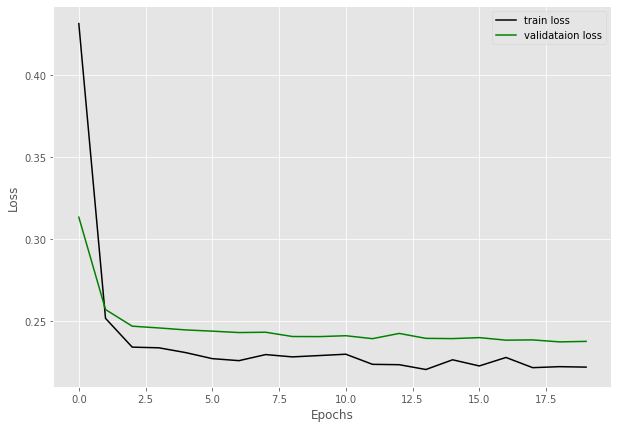

In [29]:
torch.save({
            'epoch': epochs,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': criterion,
            }, '/content/drive/MyDrive/outputs/model.pth')
# plot and save the train and validation line graphs
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='black', label='train loss')
plt.plot(valid_loss, color='green', label='validataion loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('/content/drive/MyDrive/outputs/loss.png')
plt.show()

In [48]:
#test images
import shutil
!mkdir test_images
test_csv = pd.read_csv('/content/attributes_test.csv')
for images in os.listdir('/content/classification-assignment/images'):
  if images in list(test_csv['filename']):
    shutil.copy('/content/classification-assignment/images/'+images,'/content/test_images')
#test_csv['filename']

In [4]:
!python inference.py --csv_file /content/attributes_test.csv --ckpts /content/drive/MyDrive/outputs/model.pth

lolololol /content/attributes_test.csv /content/drive/MyDrive/outputs/model.pth
/content/drive/MyDrive/outputs/model.pth /content/attributes_test.csv
inference.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),
